In [2]:
%load_ext autoreload

In [17]:

import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import MNIST, CIFAR10

%autoreload 2
from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [50]:
# Set seed, clear cache
set_seed(42)
torch.cuda.empty_cache()

train_transform = Compose([
    Resize(28),
    ToTensor(),
    # Normalize(0.1307, 0.3081),
])

# Set training static parameters and hyperparameters
parameters = dict(
    nepochs=50,
    dims_latent = 10,                              
    learning_rate=1e-3,
    batch_size=1,                                        
    transform=train_transform,
    device=set_device("cuda:1"),
    )

# Model saving settings
save_model = False
save_frequency = 5

# access all HPs through wandb.config, so logging matches execution!
config = setup_config_offline(parameters)



Cuda installed! Running on GPU GeForce RTX 2080 Ti!


## Autoencoder 1-Channel

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...
{'epoch': 0, 'mse_loss': 0.22874411940574646, 'awi2d_loss': 0.4999563992023468, 'awi1d_loss': 0.49972498416900635}
1D argidx T, v:  391 231
2D argidx T, v:  377 469


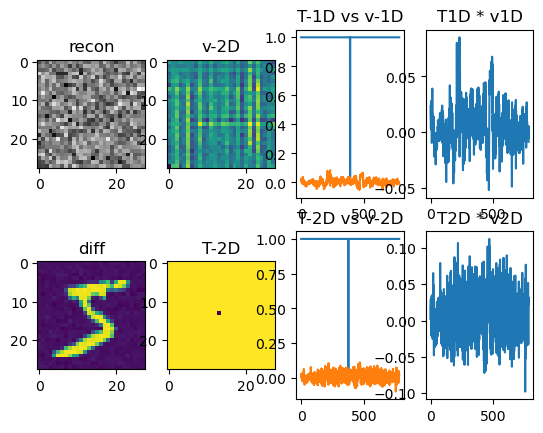

{'epoch': 49, 'mse_loss': 4.180790710961446e-05, 'awi2d_loss': 0.017673393711447716, 'awi1d_loss': 0.022708678618073463}
1D argidx T, v:  391 391
2D argidx T, v:  377 377


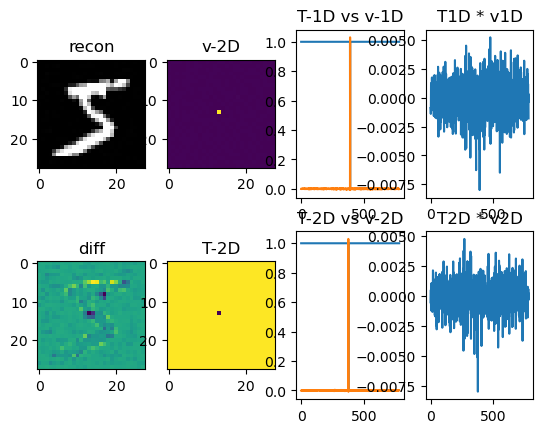

In [28]:
# Data (single image)
trainds = MNIST("./", download=False, train=True, transform=parameters["transform"])
X = trainds[0][0].unsqueeze(0)


# Model and optim
model = Autoencoder(dims_latent=2, nc=X.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


# Input / Output test
print(X.shape, model(X).shape)


# Losses: total_loss = a*awi + w*mse +  c*total_variation
w, mse =     0.0, torch.nn.MSELoss()
a1d, awi1D = 0.0,  AWILoss1D()
a2d, awi2D = 1.0,  AWILoss2D()
c, tv =      0.0,  TV()
switch_at_epoch = 10 # swtich from pure mse to total loss, set to 0 to disable    

# Send to devices
X = X.to(config.device)
model = model.to(config.device)

# Training loop
print("\n\nTraining started ...")    
for epoch in range(config.nepochs):
    model.train()
    optimizer.zero_grad()
    
    recon = model(X)
    mse_loss = mse(recon, X)
    std = 1e-4
    awi2d_loss, v2D, T2D =  awi2D(recon, X,   std=std, alpha=0., epsilon=0.) 
    awi1d_loss, v1D, T1D =  awi1D(recon, X, std=std, alpha=0. , epsilon=0.) 
    tv_loss =  tv(recon)
    
    if epoch < switch_at_epoch:
        total_loss = mse_loss
    else:
        total_loss = a2d*awi2d_loss + a1d*awi1d_loss + w*mse_loss + c*tv_loss
    total_loss.backward()
    optimizer.step()

    log = {"epoch": epoch, "mse_loss":mse_loss.item(), "awi2d_loss":awi2d_loss.item(), "awi1d_loss": awi1d_loss.item()}
    if epoch % 50 == 0 or epoch==config.nepochs-1:
        
        print(log)
        print("1D argidx T, v: ",torch.argmin(T1D).item(), torch.argmax(v1D).item())
        print("2D argidx T, v: ", torch.argmin(T2D.flatten()).item(), torch.argmax(v2D).item())
        
        v2D, v1D = v2D[0], v1D[0]
        fig, axs = plt.subplots(2,4)
        axs[0,0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
        axs[0,0].set_title("recon")

        im = axs[1,0].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
        axs[1,0].set_title("diff")

        axs[0,1].imshow(v2D.view(X.shape[2], X.shape[3]).cpu().detach().numpy())
        axs[0,1].set_title("v-2D")

        axs[1,1].imshow(T2D.cpu().detach().numpy())
        axs[1,1].set_title("T-2D")

        axs[0,2].plot(T1D.flatten().detach().cpu().numpy())
        axs[0,2].plot(v1D.detach().cpu().numpy())
        axs[0,2].set_title("T-1D vs v-1D")

        axs[1,2].plot(T2D.flatten().detach().cpu().numpy())
        axs[1,2].plot(v2D.flatten().detach().cpu().numpy())
        axs[1,2].set_title("T-2D vs v-2D")

        axs[0,3].plot((T1D.flatten()*v1D).detach().cpu().numpy())
        axs[0,3].set_title("T1D * v1D")

        axs[1,3].plot((T2D.flatten()* v2D.flatten()).detach().cpu().numpy())
        axs[1,3].set_title("T2D * v2D")
        plt.show()

## Autoencoder 3-Channel (AWLoss1D)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
{'epoch': 0, 'mse_loss': 0.05004321411252022, 'awi2d_loss': 0.37457454204559326, 'awi1d_loss': 0.48026907444000244}
1D argidx T, v:  1175 1175
2D argidx T, v:  377 377


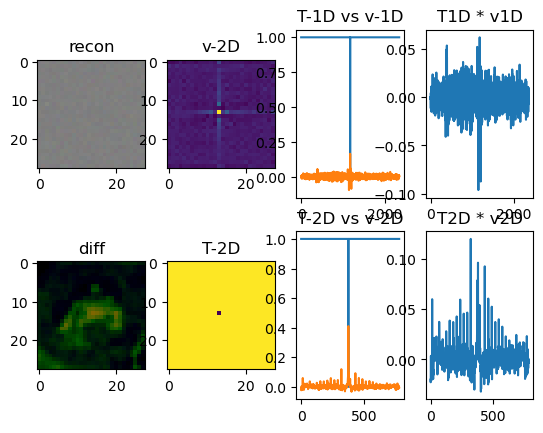

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
{'epoch': 49, 'mse_loss': 0.01955459825694561, 'awi2d_loss': 0.15314671397209167, 'awi1d_loss': 0.14117863774299622}
1D argidx T, v:  1175 1175
2D argidx T, v:  377 377


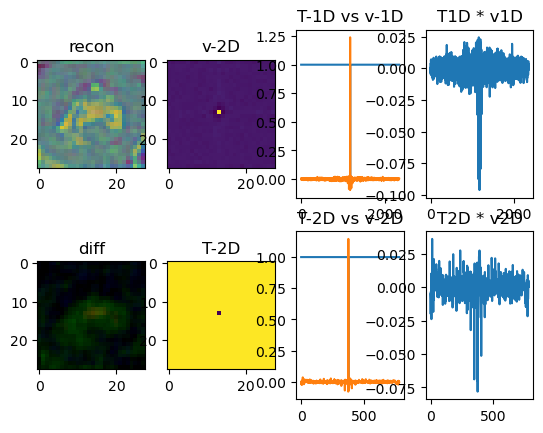

In [49]:
%autoreload 2
from losses import *
from networks import *

# Data (single image)
X = Image.open("./frog_orig.png").convert("RGB")
X = parameters["transform"](X)
X = torch.from_numpy(np.array(X)).unsqueeze(0)


# Model and optim
model = Autoencoder(dims_latent=config.dims_latent, nc=X.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


# Input / Output test
print(X.shape, model(X).shape)


# Losses: total_loss = a*awi + w*mse +  c*total_variation
w, mse =     0.0, torch.nn.MSELoss()
a1d, awi1D = 1.0,  AWILoss1D()
a2d, awi2D = 0.0,  AWILoss2D()
c, tv =      0.0,  TV()
switch_at_epoch = 10 # swtich from pure mse to total loss, set to 0 to disable    

# Send to devices
X = X.to(config.device)
model = model.to(config.device)

# Training loop
print("\n\nTraining started ...")    
for epoch in range(config.nepochs):
    model.train()
    optimizer.zero_grad()
    
    recon = model(X)
    mse_loss = mse(recon, X)
    std = 1e-4
    awi2d_loss, v2D, T2D =  awi2D(recon, X,   std=std, alpha=0., epsilon=0.) 
    awi1d_loss, v1D, T1D =  awi1D(recon, X, std=std, alpha=0. , epsilon=0.) 
    tv_loss =  tv(recon)
    
    if epoch < switch_at_epoch:
        total_loss = mse_loss
    else:
        total_loss = a2d*awi2d_loss + a1d*awi1d_loss + w*mse_loss + c*tv_loss
    total_loss.backward()
    optimizer.step()

    log = {"epoch": epoch, "mse_loss":mse_loss.item(), "awi2d_loss":awi2d_loss.item(), "awi1d_loss": awi1d_loss.item()}
    if epoch % 50 == 0 or epoch==config.nepochs-1:
        
        print(log)
        print("1D argidx T, v: ",torch.argmin(T1D).item(), torch.argmax(v1D).item())
        print("2D argidx T, v: ", torch.argmin(T2D.flatten()).item(), torch.argmax(v2D).item())
        
        v2D, v1D = v2D[0], v1D[0]
        fig, axs = plt.subplots(2,4)
        axs[0,0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), cmap="gray")
        axs[0,0].set_title("recon")

        im = axs[1,0].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy())
        axs[1,0].set_title("diff")

        axs[0,1].imshow(v2D.view(X.shape[2], X.shape[3]).cpu().detach().numpy())
        axs[0,1].set_title("v-2D")

        axs[1,1].imshow(T2D.cpu().detach().numpy())
        axs[1,1].set_title("T-2D")

        axs[0,2].plot(T1D.flatten().detach().cpu().numpy())
        axs[0,2].plot(v1D.detach().cpu().numpy())
        axs[0,2].set_title("T-1D vs v-1D")

        axs[1,2].plot(T2D.flatten().detach().cpu().numpy())
        axs[1,2].plot(v2D.flatten().detach().cpu().numpy())
        axs[1,2].set_title("T-2D vs v-2D")

        axs[0,3].plot((T1D.flatten()*v1D).detach().cpu().numpy())
        axs[0,3].set_title("T1D * v1D")

        axs[1,3].plot((T2D.flatten()* v2D.flatten()).detach().cpu().numpy())
        axs[1,3].set_title("T2D * v2D")
        plt.show()

## Autoencoder 3-Channel (AWLoss2D)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
{'epoch': 0, 'mse_loss': 0.04993516951799393, 'awi2d_loss': 0.3685828149318695, 'awi1d_loss': 0.48520427942276}
1D argidx T, v:  1175 1175
2D argidx T, v:  377 377


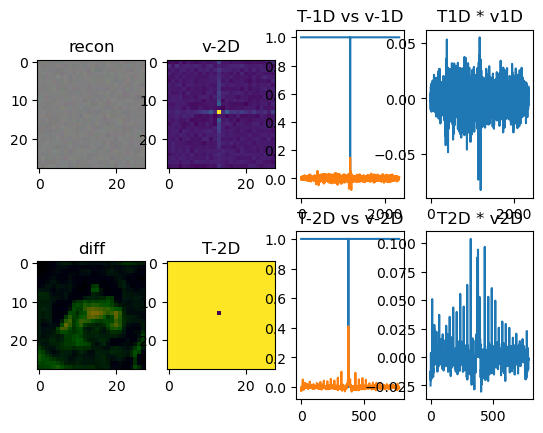

{'epoch': 49, 'mse_loss': 0.006935254205018282, 'awi2d_loss': 0.04828215762972832, 'awi1d_loss': 0.23526641726493835}
1D argidx T, v:  1175 1175
2D argidx T, v:  377 377
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


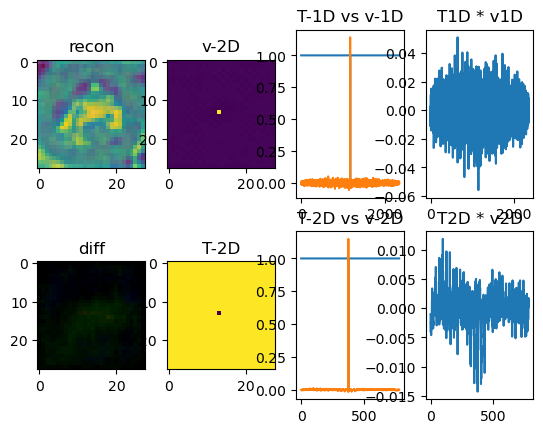

In [48]:
%autoreload 2
from losses import *
from networks import *

# Data (single image)
X = Image.open("./frog_orig.png").convert("RGB")
X = parameters["transform"](X)
X = torch.from_numpy(np.array(X)).unsqueeze(0)


# Model and optim
model = Autoencoder(dims_latent=config.dims_latent, nc=X.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


# Input / Output test
print(X.shape, model(X).shape)


# Losses: total_loss = a*awi + w*mse +  c*total_variation
w, mse =     0.0, torch.nn.MSELoss()
a1d, awi1D = 0.0,  AWILoss1D()
a2d, awi2D = 1.0,  AWILoss2D()
c, tv =      0.0,  TV()
switch_at_epoch = 10 # swtich from pure mse to total loss, set to 0 to disable    

# Send to devices
X = X.to(config.device)
model = model.to(config.device)

# Training loop
print("\n\nTraining started ...")    
for epoch in range(config.nepochs):
    model.train()
    optimizer.zero_grad()
    
    recon = model(X)
    mse_loss = mse(recon, X)
    std = 1e-4
    awi2d_loss, v2D, T2D =  awi2D(recon, X,   std=std, alpha=0., epsilon=0.) 
    awi1d_loss, v1D, T1D =  awi1D(recon, X, std=std, alpha=0. , epsilon=0.) 
    tv_loss =  tv(recon)
    
    if epoch < switch_at_epoch:
        total_loss = mse_loss
    else:
        total_loss = a2d*awi2d_loss + a1d*awi1d_loss + w*mse_loss + c*tv_loss
    total_loss.backward()
    optimizer.step()

    log = {"epoch": epoch, "mse_loss":mse_loss.item(), "awi2d_loss":awi2d_loss.item(), "awi1d_loss": awi1d_loss.item()}
    if epoch % 50 == 0 or epoch==config.nepochs-1:
        
        print(log)
        print("1D argidx T, v: ",torch.argmin(T1D).item(), torch.argmax(v1D).item())
        print("2D argidx T, v: ", torch.argmin(T2D.flatten()).item(), torch.argmax(v2D).item())
        
        v2D, v1D = v2D[0], v1D[0]
        fig, axs = plt.subplots(2,4)
        axs[0,0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), cmap="gray")
        axs[0,0].set_title("recon")

        im = axs[1,0].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy())
        axs[1,0].set_title("diff")

        axs[0,1].imshow(v2D.view(X.shape[2], X.shape[3]).cpu().detach().numpy())
        axs[0,1].set_title("v-2D")

        axs[1,1].imshow(T2D.cpu().detach().numpy())
        axs[1,1].set_title("T-2D")

        axs[0,2].plot(T1D.flatten().detach().cpu().numpy())
        axs[0,2].plot(v1D.detach().cpu().numpy())
        axs[0,2].set_title("T-1D vs v-1D")

        axs[1,2].plot(T2D.flatten().detach().cpu().numpy())
        axs[1,2].plot(v2D.flatten().detach().cpu().numpy())
        axs[1,2].set_title("T-2D vs v-2D")

        axs[0,3].plot((T1D.flatten()*v1D).detach().cpu().numpy())
        axs[0,3].set_title("T1D * v1D")

        axs[1,3].plot((T2D.flatten()* v2D.flatten()).detach().cpu().numpy())
        axs[1,3].set_title("T2D * v2D")
        plt.show()

## Autoencoder 3-Channel (MSE)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
{'epoch': 0, 'mse_loss': 0.049790289252996445, 'awi2d_loss': 1.1182374954223633, 'awi1d_loss': 0.481219619512558}
1D argidx T, v:  1175 1175
2D argidx T, v:  377 377


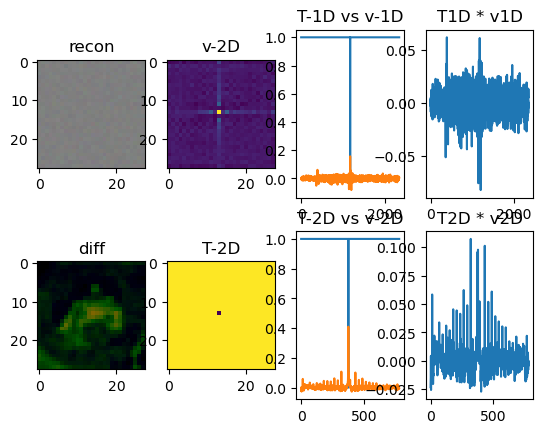

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
{'epoch': 49, 'mse_loss': 2.5980250939028338e-05, 'awi2d_loss': 0.13318811357021332, 'awi1d_loss': 0.09724566340446472}
1D argidx T, v:  1175 1175
2D argidx T, v:  377 377


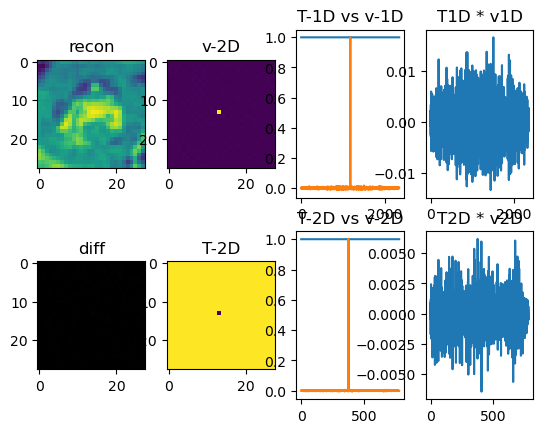

In [46]:
%autoreload 2
from losses import *
from networks import *
from PIL import Image

# Data (single image)
X = Image.open("./frog_orig.png").convert("RGB")
X = parameters["transform"](X)
X = torch.from_numpy(np.array(X)).unsqueeze(0)

# Model and optim
model = Autoencoder(dims_latent=config.dims_latent, nc=X.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


# Input / Output test
print(X.shape, model(X).shape)


# Losses: total_loss = a*awi + w*mse +  c*total_variation
w, mse =     1.0, torch.nn.MSELoss()
a1d, awi1D = 0.0,  AWILoss1D()
a2d, awi2D = 0.0,  AWILoss2D()
c, tv =      0.0,  TV()
switch_at_epoch = 10 # swtich from pure mse to total loss, set to 0 to disable    

# Send to devices
X = X.to(config.device)
model = model.to(config.device)

# Training loop
print("\n\nTraining started ...")    
for epoch in range(config.nepochs):
    model.train()
    optimizer.zero_grad()
    
    recon = model(X)
    mse_loss = mse(recon, X)
    std = 1e-4
    awi2d_loss, v2D, T2D =  awi2D(recon, X,   std=std, alpha=0., epsilon=0.) 
    awi1d_loss, v1D, T1D =  awi1D(recon, X, std=std, alpha=0. , epsilon=0.) 
    tv_loss =  tv(recon)
    
    if epoch < switch_at_epoch:
        total_loss = mse_loss
    else:
        total_loss = a2d*awi2d_loss + a1d*awi1d_loss + w*mse_loss + c*tv_loss
    total_loss.backward()
    optimizer.step()

    log = {"epoch": epoch, "mse_loss":mse_loss.item(), "awi2d_loss":awi2d_loss.item(), "awi1d_loss": awi1d_loss.item()}
    if epoch % 50 == 0 or epoch==config.nepochs-1:
        
        print(log)
        print("1D argidx T, v: ",torch.argmin(T1D).item(), torch.argmax(v1D).item())
        print("2D argidx T, v: ", torch.argmin(T2D.flatten()).item(), torch.argmax(v2D).item())
        
        v2D, v1D = v2D[0], v1D[0]
        fig, axs = plt.subplots(2,4)
        axs[0,0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), cmap="gray")
        axs[0,0].set_title("recon")

        im = axs[1,0].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy())
        axs[1,0].set_title("diff")

        axs[0,1].imshow(v2D.view(X.shape[2], X.shape[3]).cpu().detach().numpy())
        axs[0,1].set_title("v-2D")

        axs[1,1].imshow(T2D.cpu().detach().numpy())
        axs[1,1].set_title("T-2D")

        axs[0,2].plot(T1D.flatten().detach().cpu().numpy())
        axs[0,2].plot(v1D.detach().cpu().numpy())
        axs[0,2].set_title("T-1D vs v-1D")

        axs[1,2].plot(T2D.flatten().detach().cpu().numpy())
        axs[1,2].plot(v2D.flatten().detach().cpu().numpy())
        axs[1,2].set_title("T-2D vs v-2D")

        axs[0,3].plot((T1D.flatten()*v1D).detach().cpu().numpy())
        axs[0,3].set_title("T1D * v1D")

        axs[1,3].plot((T2D.flatten()* v2D.flatten()).detach().cpu().numpy())
        axs[1,3].set_title("T2D * v2D")
        plt.show()